## Automated Tree Cover Loss QC

In [1]:
import os
import numpy as np
import rasterio as rio
import fiona
import pandas as pd
from tqdm.notebook import tqdm
from rasterio.windows import from_bounds
from rasterstats import zonal_stats
from matplotlib import pyplot as plt

In [2]:
# data config

# input directory with three tiles (tree cover density, tree cover loss, and area) and admin boundary shp
DATA_DIR = 'test'
OUT_DIR = 'output'

# asset filenames
TCD_FN = 'Hansen_GFC-2019-v1.7_treecover2000_20N_100E.tif'
TCL_FN = 'Hansen_GFC-2019-v1.7_lossyear_20N_100E.tif'
AREA_FN = 'hanson_2013_area_20N_100E.tif'
SHP_FN = 'khammouan_diss.shp'

# set tree cover density threshold
treecover_threshold = 30

In [3]:
tcd_fp = os.path.join(DATA_DIR, TCD_FN)
tcl_fp = os.path.join(DATA_DIR, TCL_FN)
shp_fp = os.path.join(DATA_DIR, SHP_FN)
area_fp = os.path.join(DATA_DIR, AREA_FN)

#### Get admin area bounds

Use bounds to read a window containing the admin zone from raster tiles

In [4]:
with fiona.open(shp_fp) as src:
    bounds = src.bounds

bounds

(104.27908325195312, 16.902717590332127, 106.42545318603518, 18.26842308044425)

#### Threshold tree cover density

Generate binary mask array from the tree cover density tile

In [5]:
# read window for tree cover density tile
with rio.open(tcd_fp) as src:
    window = from_bounds(
        bounds[0],
        bounds[1],
        bounds[2],
        bounds[3],
        src.transform
    )
    tcd_arr = src.read(1, window=window)
    src_affine = src.transform
    win_affine = src.window_transform(window)

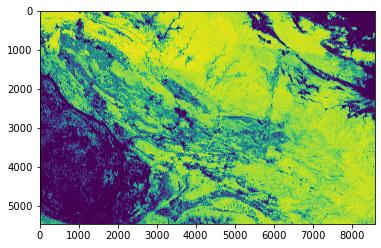

In [6]:
plt.imshow(tcd_arr)

In [7]:
# reclassify using binary threshold
tcd_arr_mask = tcd_arr.copy()
tcd_arr_mask[np.where( tcd_arr <= treecover_threshold )] = 0
tcd_arr_mask[np.where( tcd_arr > treecover_threshold )] = 1

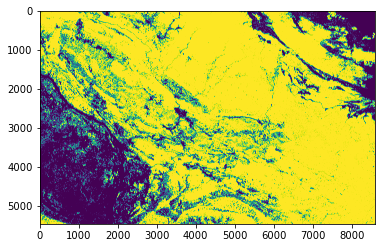

In [8]:
plt.imshow(tcd_arr_mask)

#### Set area array

Read area array and mask by tree cover density threshold

In [9]:
# read a window of area tile 
with rio.open(area_fp) as src:
    area_arr = src.read(1, window=from_bounds(
        bounds[0],
        bounds[1],
        bounds[2],
        bounds[3],
        src_affine
))

C:\Users\maanas.nukala\Anaconda3\envs\AutoQC\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


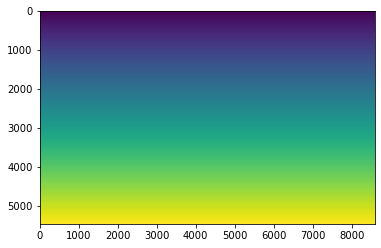

In [10]:
plt.imshow(area_arr)

In [11]:
# mask by treecover threshold array
area_mask = np.multiply(tcd_arr_mask, area_arr)

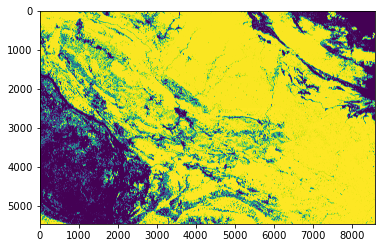

In [12]:
plt.imshow(area_mask)

#### Mask tree cover loss

Read tree cover loss from window and mask using tree cover density threshold

In [13]:
# read as np array from bounds
with rio.open(tcl_fp) as src:
    tcl_arr = src.read(1, window=from_bounds(
        bounds[0],
        bounds[1],
        bounds[2],
        bounds[3],
        src_affine
))

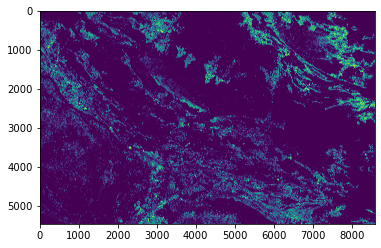

In [14]:
plt.imshow(tcl_arr)

In [15]:
# mask tree cover loss by treecover threshold
tcl_masked = np.multiply(tcd_arr_mask, tcl_arr)

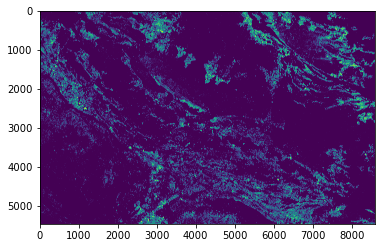

In [16]:
plt.imshow(tcl_masked)

#### Compute zonal statistics for admin boundary

In [18]:
loss_by_year_ha = {}

for year in tqdm(range(1,20)):
    
    # copy thresholded tree cover loss array
    tcl_arr_year = tcl_masked.copy()
    
    # mask by current year
    tcl_arr_year[np.where( tcl_masked != year )] = 0
    tcl_arr_year[np.where( tcl_masked == year )] = 1
    
    # convert to ha using area mask
    tcl_arr_year_area = np.multiply(area_mask, tcl_arr_year) / 10000
    
    # compute zonal stats for admin area
    zstats = zonal_stats(
        shp_fp,
        tcl_arr_year_area,
        stats='sum',
        affine=win_affine,
        nodata=-999
    )
    
    # log
    annual_loss = zstats[0]['sum']
    print(f'TCL in {year + 2000}: {int(annual_loss)} ha')
    loss_by_year_ha[year + 2000] = annual_loss

TCL in 2001: 2024 ha
TCL in 2002: 3580 ha
TCL in 2003: 3993 ha
TCL in 2004: 5432 ha
TCL in 2005: 4681 ha
TCL in 2006: 7718 ha
TCL in 2007: 9543 ha
TCL in 2008: 3120 ha
TCL in 2009: 8806 ha
TCL in 2010: 6870 ha
TCL in 2011: 10292 ha
TCL in 2012: 10444 ha
TCL in 2013: 9874 ha
TCL in 2014: 8314 ha
TCL in 2015: 8705 ha
TCL in 2016: 12457 ha
TCL in 2017: 12824 ha
TCL in 2018: 12486 ha
TCL in 2019: 15257 ha



#### Save as CSV

In [21]:
loss_df = pd.DataFrame.from_dict(loss_by_year_ha, orient='index')
loss_df = loss_df.rename(columns={0:'area_ha'})
loss_df['threshold'] = f'{treecover_threshold}%'

In [22]:
loss_df.to_csv(os.path.join(
    OUT_DIR, 
    f'{SHP_FN[:-4]}_tree_cover_loss_ha.csv'),
    index_label='year'
)